In [1]:
library(tidyverse)
library(hrbrthemes)
library(fitdistrplus)
library(fitur)
library(actuar)
library(scales)
library(Hmisc)
library(reshape2)
library(survey)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'hrbrthemes' was built under R version 4.1.3"
Warning message:
"package 'fitdistrplus' was built under R version 4.1.3"
Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: survival

Warning message:
"package 'fitur' was built under R version 4.1.3"

Attaching package: 'fitur'


The following object is masked from 'package:purrr':

    rdunif


Warning message:
"package 'actuar' was built under R version

In [2]:
# Read 1991 data

df_1991 <- read.csv("C:\\Users\\Elena.Mariani\\Documents\\Projects\\ahl_weight_loss_modelling\\Output\\hse_1991.csv") %>% 
  mutate(bmi_class = case_when(bmivalid <= 18.5 ~ "underweight",
                               bmivalid > 18.5 & bmivalid < 25 ~ "normal",
                               bmivalid >= 25 & bmivalid < 30 ~ "overweight",
                               bmivalid >= 30 ~ "obese",
                               TRUE ~ "NA"))

In [3]:
# Sample description for 1991 data

df_1991 %>% 
  group_by(sex) %>% 
  count() %>% 
  ungroup() %>% 
  mutate(perc = label_percent()(n/sum(n)))

df_1991 %>% 
  count(bmi_class) %>% 
  mutate(perc = label_percent(accuracy = 0.1)(n/sum(n)))

df_1991 %>% 
  summarise(meanAge = mean(age),
            meanW = mean(wtvalid),
            meanH = mean(htvalid),
            meanBMI = mean(bmivalid),
            sdAge = sd(age),
            sdW = sd(wtvalid),
            sdH = sd(htvalid),
            sdBMI = sd(bmivalid))

nrow(df_1991)

sex,n,perc
<int>,<int>,<chr>
1,3111,47.6%
2,3421,52.4%


bmi_class,n,perc
<chr>,<int>,<chr>
normal,3185,48.8%
obese,921,14.1%
overweight,2289,35.0%
underweight,137,2.1%


meanAge,meanW,meanH,meanBMI,sdAge,sdW,sdH,sdBMI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
44.97979,71.78405,167.6253,25.48403,18.04731,14.37887,9.717674,4.340374


[1] 6532

In [4]:
# Read 2019 data

df <- read.csv("C:/Users/Elena.Mariani/Documents/Projects/ahl_weight_loss_modelling/Data/calorie_deficit_scenarios_w_imd.csv", sep = ",", fileEncoding="UTF-8-BOM") 

# BMI restriction

bmi_out <- df  %>% filter(BMI_est >= 45 | BMI_est <= 15)

df1 <- df  %>% filter(!X %in% bmi_out$X)

# weight restriction

outlier <- boxplot.stats(df1$Wt_est)$out

wgt_out <- df1  %>% filter(Wt_est %in% outlier)

df2 <- df1[which(!df1$Wt_est %in% outlier),] 



In [5]:
# descriptives for BMI and weight restrictions

sum(bmi_out$sample_weight)

sum(wgt_out$sample_weight)

sum(df2$sample_weight)/sum(df$sample_weight)-1

[1] 107.3404

[1] 98.97536

[1] -0.02596689

In [6]:
# analyse bmi restriction

bmi_out %>% 
  count(Sex, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

bmi_out %>% 
  count(BMI_class, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

bmi_out %>% 
  summarise(meanAge = wtd.mean(Age_est, weights = sample_weight),
            meanW = wtd.mean(Wt_est, weights = sample_weight),
            meanH = wtd.mean(Ht_est, weights = sample_weight),
            meanBMI = wtd.mean(BMI_est, weights = sample_weight))

Sex,n,perc
<chr>,<dbl>,<chr>
female,80.69886,75%
male,26.64155,25%


BMI_class,n,perc
<chr>,<dbl>,<chr>
obese,101.366883,94%
underweight,5.973525,6%


meanAge,meanW,meanH,meanBMI
<dbl>,<dbl>,<dbl>,<dbl>
46.97865,129.4809,163.794,48.13931


In [7]:
# analyse outliers

wgt_out %>% 
  count(Sex, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

wgt_out %>% 
  count(BMI_class, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

wgt_out %>% 
  summarise(meanAge = wtd.mean(Age_est, weights = sample_weight),
            meanW = wtd.mean(Wt_est, weights = sample_weight),
            meanH = wtd.mean(Ht_est, weights = sample_weight),
            meanBMI = wtd.mean(BMI_est, weights = sample_weight))

Sex,n,perc
<chr>,<dbl>,<chr>
female,11.22896,11%
male,87.74640,89%


BMI_class,n,perc
<chr>,<dbl>,<chr>
obese,98.97536,100%


meanAge,meanW,meanH,meanBMI
<dbl>,<dbl>,<dbl>,<dbl>
41.11802,132.8205,182.4447,39.99814


In [8]:
sum(df2$sample_weight)

df2 %>% 
  count(Sex, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

df2 %>% 
  count(BMI_class, wt = sample_weight) %>% 
  mutate(perc = label_percent()(n/sum(n)))

df2 %>% 
  summarise(meanAge = wtd.mean(Age_est, weights = sample_weight),
            meanW = wtd.mean(Wt_est, weights = sample_weight),
            meanH = wtd.mean(Ht_est, weights = sample_weight),
            meanBMI = wtd.mean(BMI_est, weights = sample_weight),
            sdAge = sqrt(wtd.var(Age_est, weights = sample_weight)),
            sdW =sqrt( wtd.var(Wt_est, weights = sample_weight)),
            sdH = sqrt(wtd.var(Ht_est, weights = sample_weight)),
            sdBMI = sqrt(wtd.var(BMI_est, weights = sample_weight)))


[1] 7739.023

Sex,n,perc
<chr>,<dbl>,<chr>
female,3936.794,50.9%
male,3802.229,49.1%


BMI_class,n,perc
<chr>,<dbl>,<chr>
normal,2733.9320,35.3%
obese,2042.5459,26.4%
overweight,2823.8141,36.5%
underweight,138.7313,1.8%


meanAge,meanW,meanH,meanBMI,sdAge,sdW,sdH,sdBMI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47.9902,77.26082,168.4626,27.17517,19.08919,16.28943,9.990362,5.079456


In [9]:
# split data by sex

df_m <- df2 %>% filter(Sex == "male")
df_f <- df2 %>% filter(Sex == "female")

df_1991_m <- df_1991 %>% filter(sex == 1)
df_1991_f <- df_1991 %>% filter(sex == 2)


In [10]:
# women

old_f <- df_1991_f %>% 
  dplyr::select(bmivalid, wtvalid, htvalid, age) %>% 
  mutate(sample_weight = 1) %>% 
  rename(height = htvalid,
         weight = wtvalid,
         bmi = bmivalid) %>% 
  mutate(intake = .0278*(weight^2) + 9.2893*weight + 1528.9) %>% 
  mutate(sex = "Female")

actual_f <- df_f %>% 
  dplyr::select(Ht_est, BMI_est, Wt_est, sample_weight, Age_est) %>% 
  rename(height = Ht_est,
         bmi = BMI_est,
         weight = Wt_est,
        age = Age_est) %>% 
  mutate(intake = .0278*(weight^2) + 9.2893*weight + 1528.9) %>% 
  mutate(sex = "Female")

all_f <- rbind(old_f %>% mutate(type = "1991"),
               actual_f %>% mutate(type = "2019"))

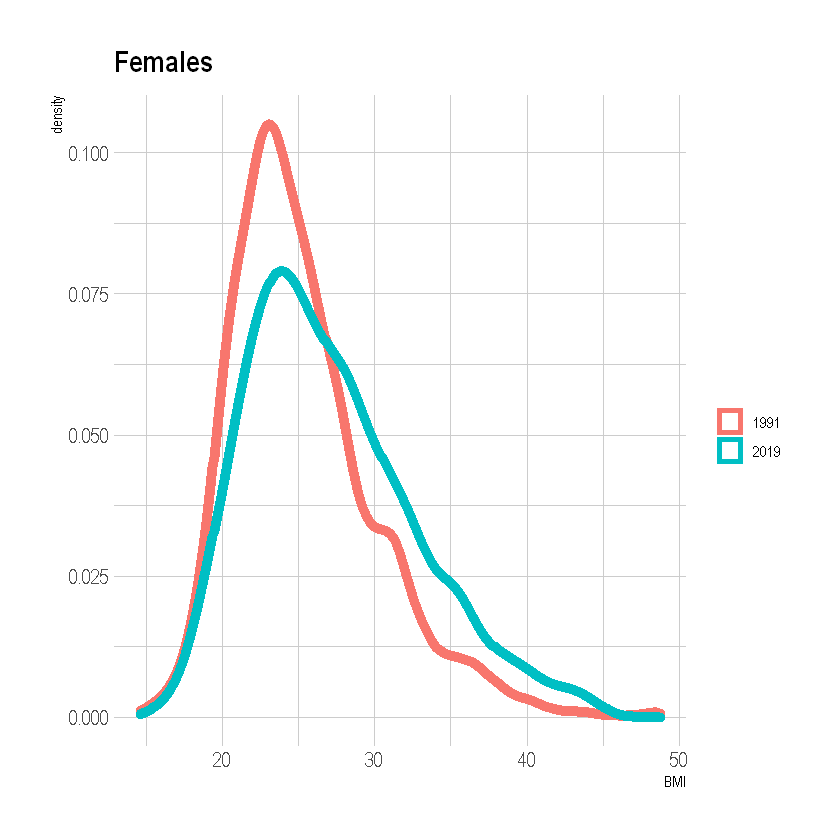

In [15]:
ggplot(all_f, aes(x = bmi, group = type, color = type)) + 
  geom_density(aes(weight = sample_weight), size = 3) +
  labs(x = "BMI",
       color = "",
       title = "Females") +
  theme_ipsum()

In [16]:
# men

old_m <- df_1991_m %>% 
  dplyr::select(bmivalid, wtvalid, htvalid, age) %>% 
  mutate(sample_weight = 1) %>% 
  rename(height = htvalid,
         weight = wtvalid,
         bmi = bmivalid) %>% 
  mutate(intake = -.0971*(weight^2) + 40.853*weight + 323.59) %>% 
  mutate(sex = "Male")

actual_m <- df_m %>% 
  dplyr::select(Ht_est, BMI_est, Wt_est, sample_weight, Age_est) %>% 
  rename(height = Ht_est,
         bmi = BMI_est,
         weight = Wt_est,
        age = Age_est) %>% 
  mutate(intake = -.0971*(weight^2) + 40.853*weight + 323.59) %>% 
  mutate(sex = "Male")

all_m <- rbind(old_m %>% mutate(type = "1991"),
               actual_m %>% mutate(type = "2019"))

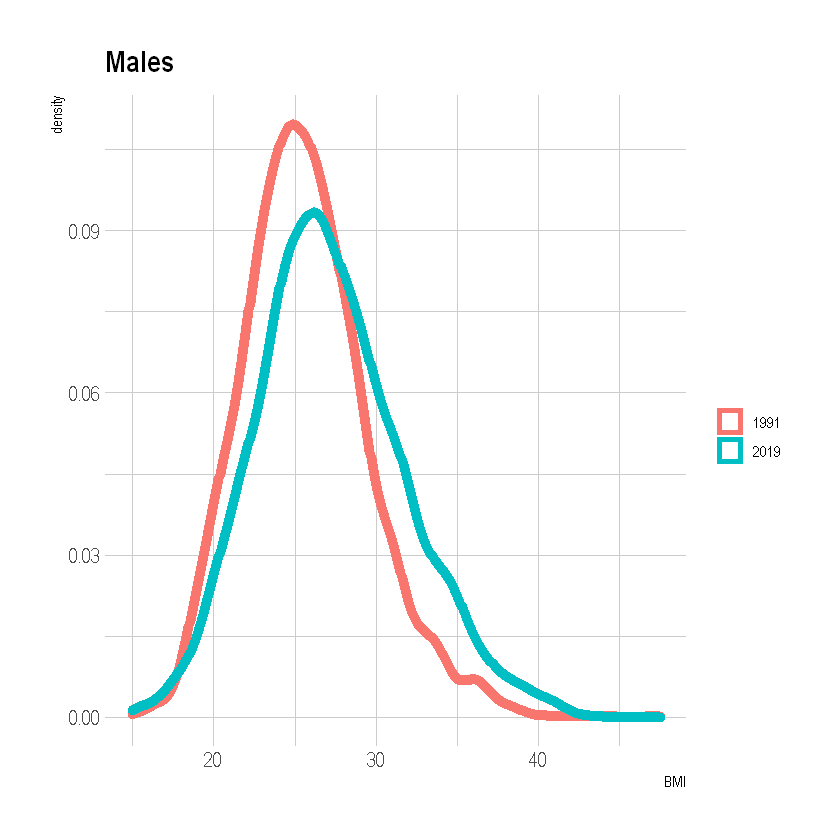

In [17]:
ggplot(all_m, aes(x = bmi, group = type, color = type)) + 
  geom_density(aes(weight = sample_weight), size = 3) +
  labs(x = "BMI",
       color = "",
       title = "Males") +
  theme_ipsum()

In [18]:
# combine all old

all_o <- rbind(old_f, old_m)

# combine all actual

all_a <- rbind(actual_f, actual_m) %>% 
  mutate(bmi_class = case_when(bmi <= 18.5 ~ "underweight",
                               bmi > 18.5 & bmi < 25 ~ "normal",
                               bmi >= 25 & bmi < 30 ~ "overweight",
                               bmi >= 30 ~ "obese",
                               TRUE ~ "NA"))

# proportions of actual

prop_a <- all_a  %>% 
  count(bmi_class, wt = sample_weight) %>% 
  mutate(freq = n/sum(n))

prop_a

obese <- prop_a[which(prop_a$bmi_class == "obese"),]$freq
over <- prop_a[which(prop_a$bmi_class == "overweight"),]$freq
normal <- prop_a[which(prop_a$bmi_class == "normal"),]$freq
under <- prop_a[which(prop_a$bmi_class == "underweight"),]$freq

cut_1 <- wtd.quantile(all_o$bmi, probs = under, all_o$sample_weight)   
cut_2 <- unname( wtd.quantile(all_o$bmi, probs = 1 - obese - over, all_o$sample_weight))
cut_3 <- unname( wtd.quantile(all_o$bmi, probs = 1 - obese, all_o$sample_weight))

cut_1
cut_2
cut_3

# add alternative bmi categories to simulated

all_o <- all_o %>% 
  mutate(bmi_class = case_when(bmi <= cut_1 ~ "underweight",
                               bmi > cut_1 & bmi < cut_2 ~ "normal",
                               bmi >= cut_2 & bmi < cut_3 ~ "overweight",
                               bmi >= cut_3 ~ "obese",
                               TRUE ~ "NA"))

# combine all genders

all <- rbind(all_o %>% mutate(type = "1991"), all_a %>% mutate(type = "2019")) %>% mutate(id = seq_len(n()))

bmi_class,n,freq
<chr>,<dbl>,<dbl>
normal,2733.9320,0.3532658
obese,2042.5459,0.2639281
overweight,2823.8141,0.3648799
underweight,138.7313,0.0179262


1.79% 
18.3952

[1] 23.65733

[1] 27.6687

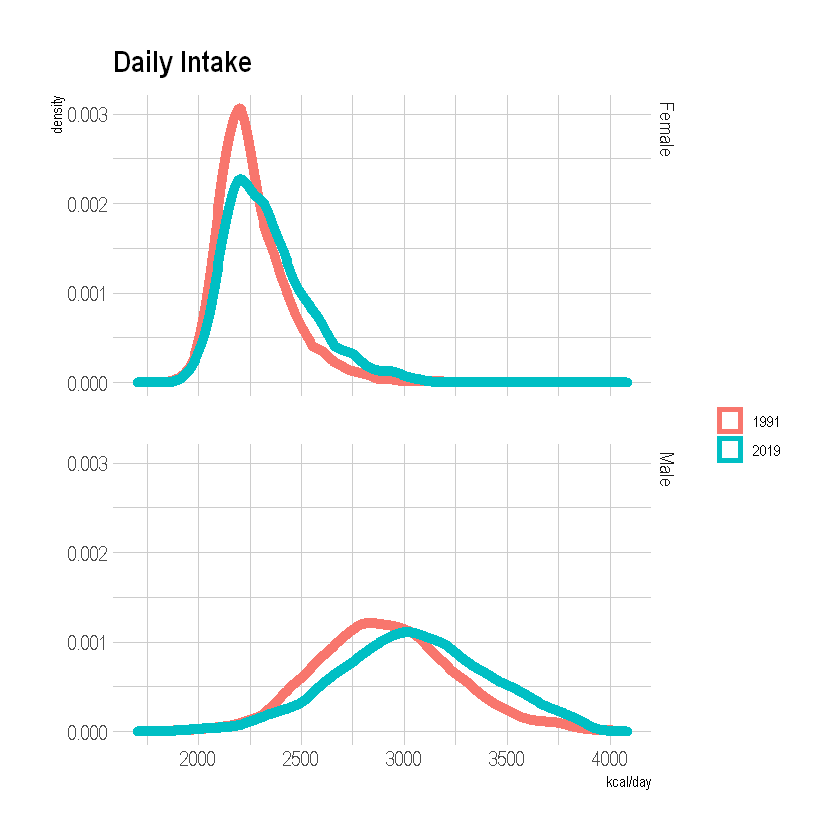

In [19]:
ggplot(all, aes(x = intake, group = type, color = type)) + 
  geom_density(aes(weight = sample_weight), size = 3) +
facet_grid(sex ~ .) +
  labs(x = "kcal/day",
       color = "",
       title = "Daily Intake") +
  theme_ipsum()

In [28]:
# Mean daily intake 

all %>% 
  group_by(bmi_class, type, sex) %>% 
  summarise(intakem = wtd.mean(intake, weight = sample_weight)) %>% 
  dcast(., bmi_class ~ type + sex, value.var = "intakem") %>% 
  mutate(diff_f = `2019_Female` - `1991_Female`,
         diff_m = `2019_Male` - `1991_Male`,
         perc_f = diff_f/`1991_Female`*100,
         perc_m = diff_m/`1991_Male`*100)

`summarise()` has grouped output by 'bmi_class', 'type'. You can override using the `.groups` argument.



bmi_class,1991_Female,1991_Male,2019_Female,2019_Male,diff_f,diff_m,perc_f,perc_m
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
normal,2149.198,2617.730,2180.150,2722.828,30.95248,105.09872,1.4401877,4.014881
obese,2474.954,3263.481,2580.496,3452.858,105.54209,189.37701,4.2644067,5.802915
overweight,2262.937,2912.217,2328.541,3073.419,65.60363,161.20210,2.8990475,5.535374
underweight,2006.666,2192.091,2017.484,2160.099,10.81848,-31.99218,0.5391271,-1.459437


In [68]:
dclus2 <- svydesign(id=~id, weights = ~sample_weight, data=all)

funDiff <- function(bmi_class_c, sex_c){
    sub <- subset(dclus2, sex == sex_c & bmi_class == bmi_class_c)
    tt<-svyttest(intake~type, sub)
    return(data.frame(sex = sex_c, bmi_class = bmi_class_c, confint(tt, level=0.95)))
    }

In [69]:
list <- expand.grid(sex_c = unique(all$sex), bmi_class_c = unique(all$bmi_class))

pmap_dfr(list, funDiff)  %>% arrange(sex)

,sex,bmi_class,X2.5..,X97.5..
,<fct>,<fct>,<dbl>,<dbl>
type2019...1,Female,normal,25.044671,36.86030
type2019...2,Female,overweight,58.526267,72.68099
type2019...3,Female,obese,91.001673,120.08251
type2019...4,Female,underweight,-7.401115,29.03808
type2019...5,Male,normal,85.283010,124.91444
type2019...6,Male,overweight,145.876389,176.52781
type2019...7,Male,obese,167.676238,211.07778
type2019...8,Male,underweight,-127.535248,63.55088


In [67]:
list

sex_c,bmi_class_c
<fct>,<fct>
Female,normal
Male,normal
Female,overweight
Male,overweight
Female,obese
Male,obese
Female,underweight
Male,underweight


In [71]:
# Mean body weight

all %>% 
  group_by(bmi_class, type, sex) %>% 
  summarise(weightm = wtd.mean(weight, weight = sample_weight)) %>% 
  dcast(., bmi_class ~ type + sex, value.var = "weightm") %>% 
  mutate(diff_f = `2019_Female` - `1991_Female`,
         diff_m = `2019_Male` - `1991_Male`,
         perc_f = diff_f/`1991_Female`*100,
         perc_m = diff_m/`1991_Male`*100)

`summarise()` has grouped output by 'bmi_class', 'type'. You can override using the `.groups` argument.



bmi_class,1991_Female,1991_Male,2019_Female,2019_Male,diff_f,diff_m,perc_f,perc_m
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
normal,56.96543,66.91151,59.41407,70.79330,2.4486342,3.881799,4.298456,5.801392
obese,81.55080,92.63275,89.06221,101.17186,7.5114114,8.539110,9.210714,9.218241
overweight,65.90790,77.92117,70.89075,84.41079,4.9828572,6.489618,7.560334,8.328439
underweight,45.23494,52.30571,46.15646,51.29119,0.9215192,-1.014527,2.037185,-1.939611
